In [2]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import pandas as pd
ot.RandomGenerator.SetSeed(42)
np.random.seed(42)

### Stick Breacking

In [3]:
def dp_by_stick_breaking(alpha=1.0, tau=1e-3, base_measure_sampler=None):
    
    weights = []
    thetas = []
    r = 1.0 

    beta_dist = ot.Beta(1.0, alpha, 0.0, 1.0)       

    while r > tau:
        v_k = beta_dist.getRealization()[0]
        w_k = v_k * r
        weights.append(w_k)
        r *= (1.0 - v_k)

        theta_k = base_measure_sampler.getRealization()[0]
        thetas.append(theta_k)

    return weights, thetas

dim = 2
def sample_from_normal(d=1):
    return ot.Normal(d)

weights, thetas = dp_by_stick_breaking(alpha=1.0, tau=1e-3, base_measure_sampler=sample_from_normal(dim))

for i, (w, theta) in enumerate(zip(weights, thetas)):
    print(f"Composante {i} : poids = {w} ; theta = {theta}")

print("Nombre de composantes :", len(weights))
print("Somme des poid (proche de 1):", sum(weights))

Composante 0 : poids = 0.06106728369067027 ; theta = 0.4699693066515363
Composante 1 : poids = 0.611377726181422 ; theta = 0.6332114586915741
Composante 2 : poids = 0.22953570815599983 ; theta = 0.5942997843832281
Composante 3 : poids = 0.016701606913123838 ; theta = -0.16295938847015162
Composante 4 : poids = 0.03527066977660555 ; theta = 0.03363629395846301
Composante 5 : poids = 0.015098561553494719 ; theta = 0.21416779564706206
Composante 6 : poids = 0.029215870496745122 ; theta = 0.24660951800549036
Composante 7 : poids = 0.001402196498726134 ; theta = 1.3652997155242619
Nombre de composantes : 8
Somme des poid (proche de 1): 0.9996696232667874


# DPMM avec prior informatif (mélange de NIW)

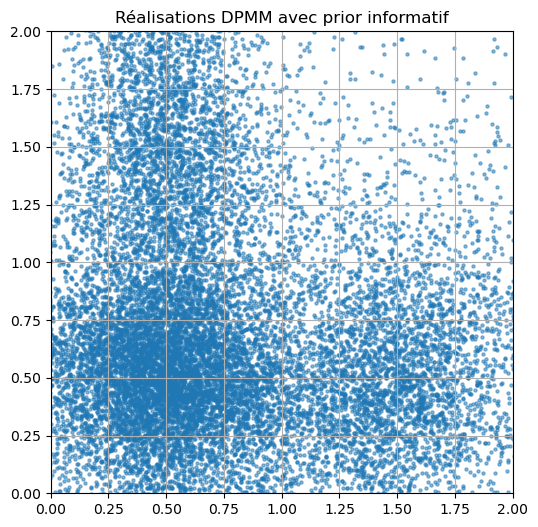

In [4]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invwishart
#ot.RandomGenerator.SetSeed(42)
#np.random.seed(42)


dim = 2
n_samples = 20000
alpha = 50
tau = 1e-2  # Seuil pour arrêt du SB

means_base = [
    [0.5, 0.5],
    [1.5, 0.5],
    [0.5, 1.5],
    [1.5, 1.5]
]
weights_base = np.array([2.0, 1.0, 0.5, 0.1])
weights_base /= weights_base.sum()

lambda_0 = 50.0
nu_0 = 4
Psi_0 = ot.CovarianceMatrix([[0.26, 0.00], [0.00, 0.26]])
#Psi_0 = ot.CovarianceMatrix([[0.13, 0.00], [0.00, 0.13]])
 

def sample_mixture_niw():
    base_idx = np.random.choice(len(means_base), p=weights_base)
    mu_0 = ot.Point(means_base[base_idx])

    Sigma = ot.InverseWishart(Psi_0, nu_0).getRealizationAsMatrix()
    mu = ot.Normal(mu_0, ot.CovarianceMatrix(Sigma / lambda_0)).getRealization()

    return mu, Sigma

def stick_breaking(alpha, tau=1e-3):
    weights = []
    r = 1.0
    while r > tau:
        v = ot.Beta(1.0, alpha, 0.0, 1.0).getRealization()[0]
        w = v * r
        weights.append(w)
        r *= (1 - v)
    return np.array(weights) / np.sum(weights)

def sample_dpmm(n_samples=1000):
    weights = stick_breaking(alpha, tau)
    n_prior = len(weights)
    prior = [sample_mixture_niw() for _ in range(n_prior)]

    data = []
    for _ in range(n_samples):
        k = np.random.choice(n_prior, p=weights)
        mu_k, sigma_k = prior[k]
        point = ot.Normal(mu_k, sigma_k).getRealization()
        data.append(list(point))

    return np.array(data)


# ===== Visualisation =====
samples = sample_dpmm(n_samples)

plt.figure(figsize=(7, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.title("Réalisations DPMM avec prior informatif")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()


##### Heatmap et lignes de niveau de la densité du DPMM simulé

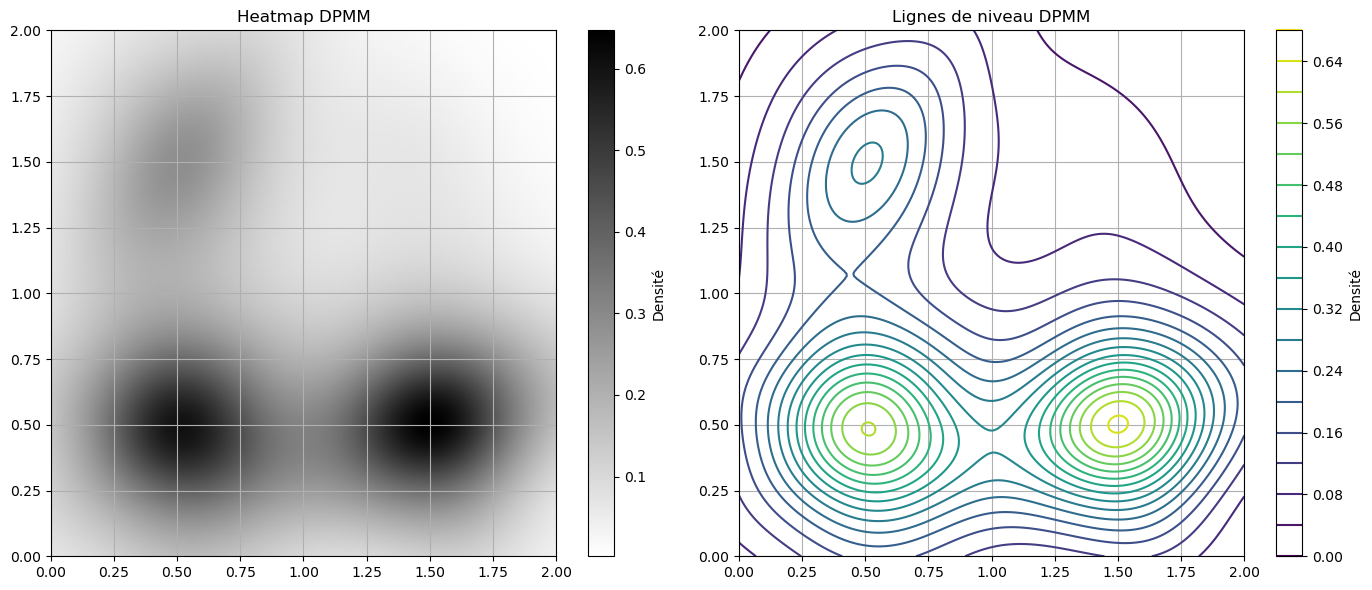

In [13]:
def density_dpmm(n_samples=1000):
    weights = stick_breaking(alpha, tau)
    n_prior = len(weights)
    prior = [sample_mixture_niw() for _ in range(n_prior)]

    componants = [ot.Normal(mu, sigma) for mu, sigma in prior]
    mixture = ot.Mixture(componants, weights)
    return mixture

mixture_density = density_dpmm(n_samples)

# Grille 
x = np.linspace(0, 2, 200)
y = np.linspace(0, 2, 200)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])

Z = np.array([mixture_density.computePDF(ot.Point(p)) for p in points])
Z = Z.reshape(X.shape)

# ==================== Affichage heatmap et lignes de niveau ====================
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

heatmap = axs[0].imshow(Z, extent=[0, 2, 0, 2], origin='lower', cmap='gray_r', aspect='auto')
axs[0].set_title("Heatmap DPMM")
axs[0].grid(True)
fig.colorbar(heatmap, ax=axs[0], label="Densité")

contour = axs[1].contour(X, Y, Z, levels=20, cmap='viridis')
axs[1].set_title("Lignes de niveau DPMM")
axs[1].grid(True)
fig.colorbar(contour, ax=axs[1], label="Densité")

plt.tight_layout()
plt.show()


##### Moyenne empirique de la densité du DPMM 

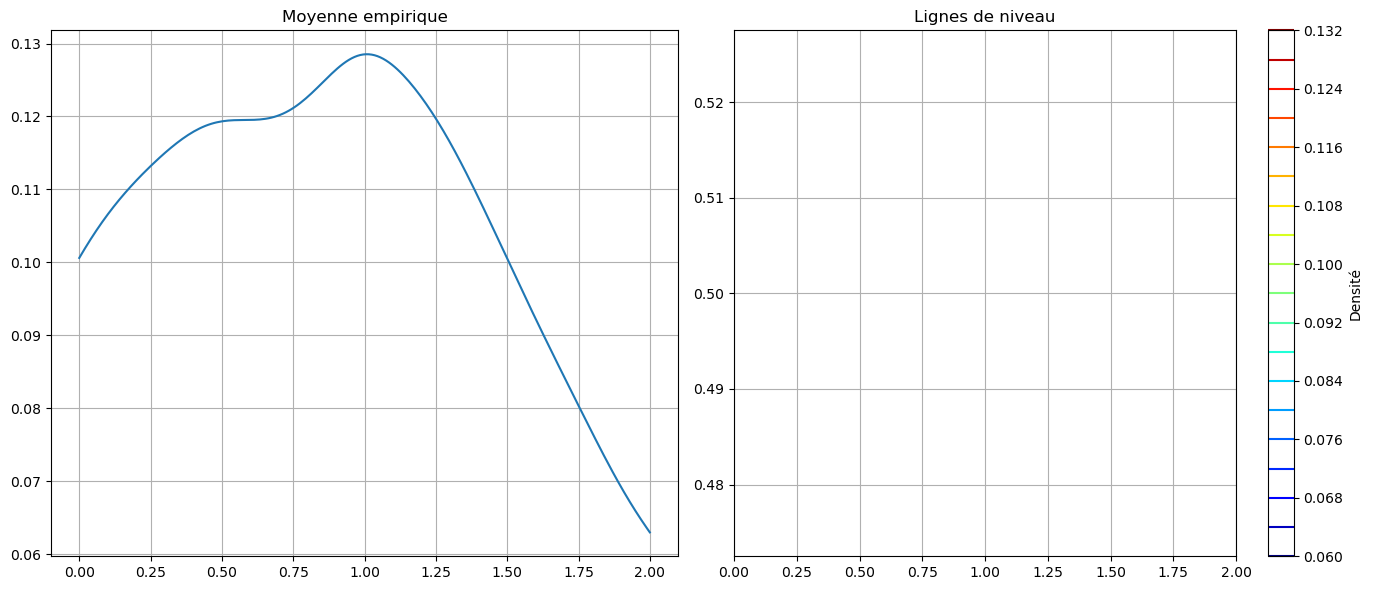

In [ ]:
dim = 2
alpha = 50
tau = 1e-2
N = 50 

means_base = [
    [0.5, 0.5],
    [1.5, 0.5],
    [0.5, 1.5],
    [1.5, 1.5]
]
weights_base = np.array([2.0, 1.0, 0.5, 0.1])
weights_base /= weights_base.sum()

lambda_0 = 0.1
nu_0 = 4
Psi_0 = ot.CovarianceMatrix([[0.26, 0.00], [0.00, 0.26]])

def sample_mixture_niw():
    base_idx = np.random.choice(len(means_base), p=weights_base)
    mu_0 = ot.Point(means_base[base_idx])
    Sigma = ot.InverseWishart(Psi_0, nu_0).getRealizationAsMatrix()
    mu = ot.Normal(mu_0, ot.CovarianceMatrix(Sigma / lambda_0)).getRealization()
    return mu, Sigma

def stick_breaking(alpha, tau=1e-3):
    weights = []
    r = 1.0
    while r > tau:
        v = ot.Beta(1.0, alpha, 0.0, 1.0).getRealization()[0]
        w = v * r
        weights.append(w)
        r *= (1 - v)
    return np.array(weights) / np.sum(weights)

def density_dpmm():
    weights = stick_breaking(alpha, tau)
    prior = [sample_mixture_niw() for _ in range(len(weights))]
    components = [ot.Normal(mu, sigma) for mu, sigma in prior]
    return ot.Mixture(components, weights)

x = np.linspace(0, 2, 200)
y = np.full(200, 0.5)
#y = np.linspace(0, 2, 200)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])


# ==================== Calcul de la moyenne empirique ====================
Z_sum = np.zeros_like(X)
for _ in range(N) :
    mixture = density_dpmm()
    Z = np.array([mixture.computePDF(ot.Point(p)) for p in points]).reshape(X.shape)
    Z_sum += Z

Z_mean = Z_sum / N


# ==================== Affichage heatmap et lignes de niveau ====================
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

heatmap = axs[0].imshow(Z_mean, extent=[0, 2, 0, 2], origin='lower', cmap='jet', aspect='auto')
#marginal = axs[0].plot(x, Z_mean[50])
axs[0].set_title(f"Moyenne empirique")
axs[0].grid(True)
fig.colorbar(heatmap, ax=axs[0], label="Densité")

contour = axs[1].contour(X, Y, Z_mean, levels=20, cmap='jet')
axs[1].set_title("Lignes de niveau")
axs[1].grid(True)
fig.colorbar(contour, ax=axs[1], label="Densité")

plt.tight_layout()
plt.show()


### Simulation de la densité de la vraie loi du zonage sismotectonique (notée $f_0$)

$$
f_0(x) ~=~ \frac{\sum^{J}_{j=1} w_{0,j} ~ \mathbb{1}_{S_{0,j}}(x)}{\sum^{J}_{j=1} w_{0,j} ~ A_{0,j}}
$$

où $S_{0,1}, \ldots, S_{0,J}$ est une partition de $\Omega$ et représente les zones d'un zonage sismotectonique et chaque $A_{0,j}$ est la surface de $S_{0,j}$.

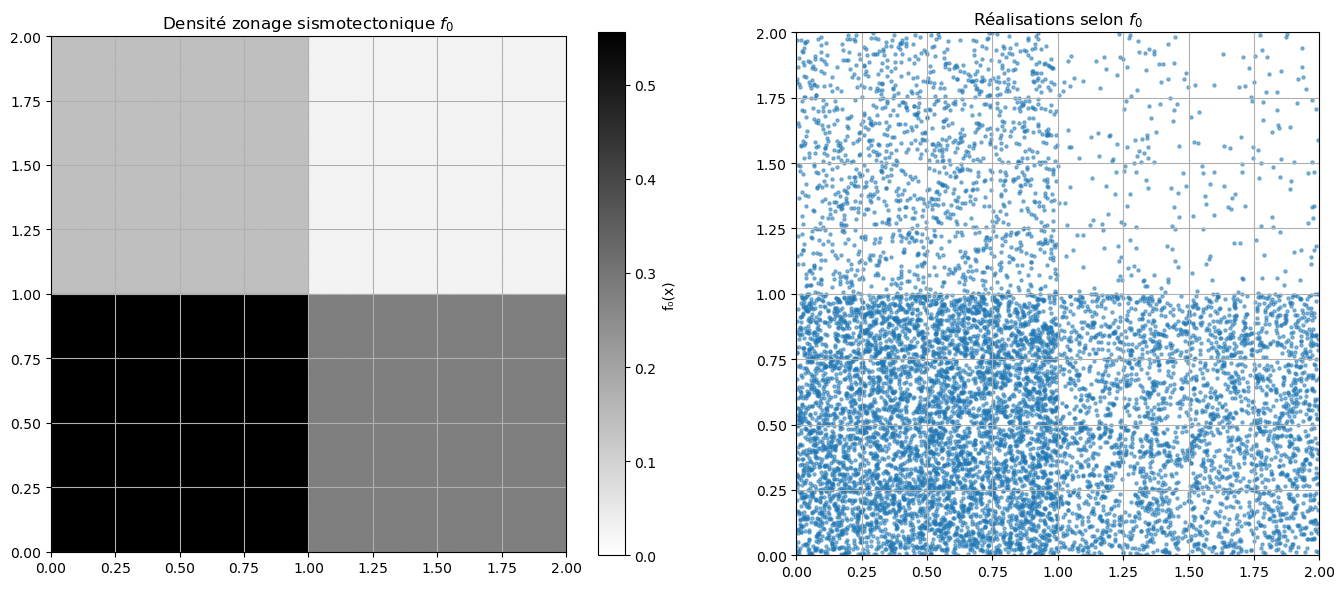

In [12]:
# Grille 2x2 
#J = 4
n_rows, n_cols = 2, 2
x_lim = np.linspace(0, 2, n_cols + 1)
y_lim = np.linspace(0, 2, n_rows + 1)

weights_base = np.array([2.0, 1.0, 0.5, 0.1])
weights_base /= weights_base.sum()

A = (x_lim[1] - x_lim[0]) * (y_lim[1] - y_lim[0])
areas = np.full(4, A)

def f0_density(x, y):
    for i in range(n_rows):
        for j in range(n_cols):
            x0, x1 = x_lim[j], x_lim[j+1]
            y0, y1 = y_lim[i], y_lim[i+1]
            idx = i * n_cols + j
            if x0 <= x < x1 and y0 <= y < y1:
                return weights_base[idx] / np.sum(weights_base * areas)
    return 0.0

probs = weights_base * areas
probs /= probs.sum()


zones = []
for i in range(n_rows):
    for j in range(n_cols):
        x0, x1 = x_lim[j], x_lim[j+1]
        y0, y1 = y_lim[i], y_lim[i+1]
        zones.append(((x0, x1), (y0, y1)))

def sample_f0(n_samples=10000):
    data = []
    for _ in range(n_samples):
        idx = np.random.choice(len(zones), p=probs)
        (x0, x1), (y0, y1) = zones[idx]
        x = ot.Uniform(x0, x1).getRealization()[0]
        y = ot.Uniform(y0, y1).getRealization()[0]
        data.append([x, y])
    return np.array(data)


x = np.linspace(0, 2, 1000)
y = np.linspace(0, 2, 1000)
X, Y = np.meshgrid(x, y)
Z = np.vectorize(f0_density)(X, Y)
samples = sample_f0(n_samples=10000)

# ==================== Affichage heatmap et réalisations de f_0 ====================
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

im = axs[0].imshow(Z, extent=(0, 2, 0, 2), origin='lower', cmap='gray_r')
axs[0].set_title("Densité zonage sismotectonique $f_0$")
axs[0].grid(True)
axs[0].set_aspect('equal')
fig.colorbar(im, ax=axs[0], label="f₀(x)")

axs[1].scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5)
axs[1].set_title("Réalisations selon $f_0$")
axs[1].set_xlim(0, 2)
axs[1].set_ylim(0, 2)
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

### Simulation de la densité de l'approximation par des gaussiennes de la loi du zonage sismotectonique (notée $\tilde{f_0}$)

$$
\tilde{f}_0(x) ~=~ \frac{1}{\sum^{J}_{j=1} w_{0,j}}\sum^{J}_{j=1} w_{0,j} ~ \mathcal{N}(\mu_{0,j}, \Sigma_{0,j})
$$

avec $\mu_{0,j}$ les centroides des zones $S_{0.j}$ et $\Sigma_{0,j}$ les diamètres d'ellipses.

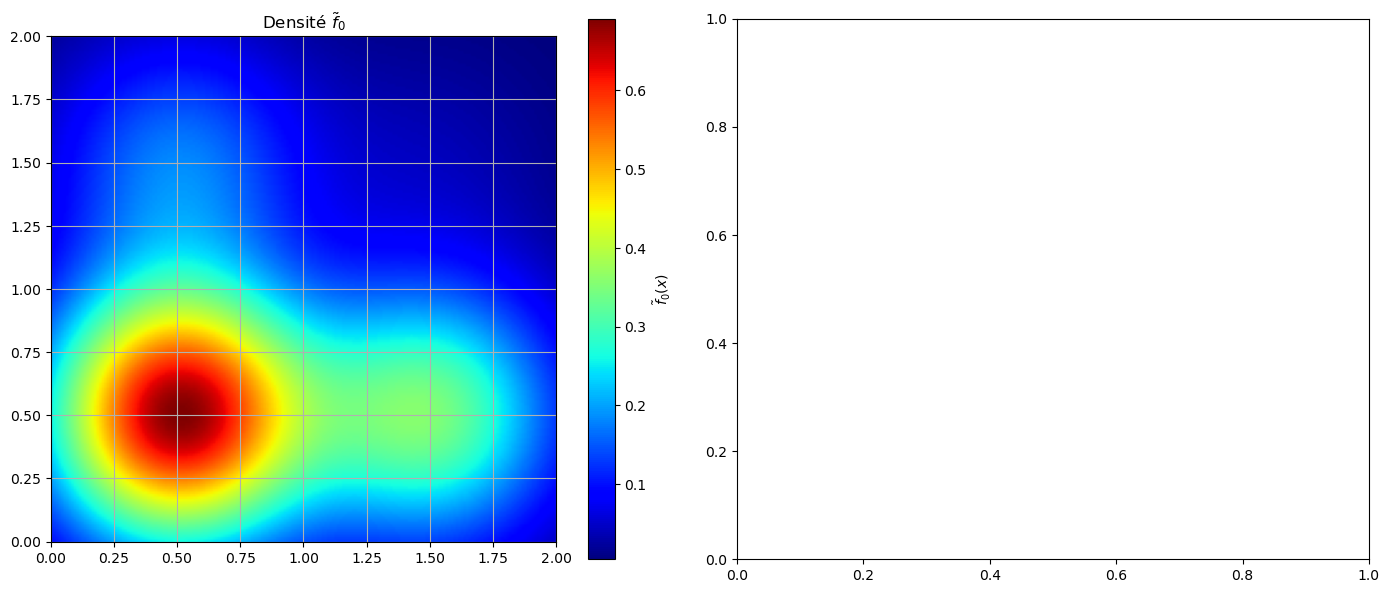

In [ ]:
n_rows, n_cols = 2, 2
x_lim = np.linspace(0, 2, n_cols + 1)
y_lim = np.linspace(0, 2, n_rows + 1)

weights = np.array([2.0, 1.0, 0.5, 0.1])
weights /= weights.sum()

A = (x_lim[1] - x_lim[0]) * (y_lim[1] - y_lim[0])
areas = np.full(len(weights), A)

mus = []
sigmas = []

for i in range(n_rows):
    for j in range(n_cols):
        x0, x1 = x_lim[j], x_lim[j+1]
        y0, y1 = y_lim[i], y_lim[i+1]

        mu = [(x0 + x1)/2, (y0 + y1)/2]
        mus.append(ot.Point(mu))
        
        sigma = ot.CovarianceMatrix(2)
        sigma[0, 0] = (np.sqrt(2)/(2*1.96))**2
        sigma[1,1] = (np.sqrt(2)/(2*1.96))**2
        sigmas.append(sigma)

def f0_tilde_density(x, y):
    pt = ot.Point([x, y])
    num = 0.0
    for w, mu, Sigma in zip(weights, mus, sigmas):
        normal = ot.Normal(mu, Sigma)
        num += w * normal.computePDF(pt)
    return num 

def sample_from_f0_tilde(n_samples=10000):
    probs = weights * areas
    probs /= probs.sum()

    data = []
    for _ in range(n_samples):
        idx = np.random.choice(len(weights), p=probs)
        mu = mus[idx]
        Sigma = sigmas[idx]
        sample = ot.Normal(mu, Sigma).getRealization()
        data.append([sample[0], sample[1]])

    return np.array(data)


x = np.linspace(0, 2, 200)
y = np.linspace(0, 2, 200)
X, Y = np.meshgrid(x, y)
Z = np.vectorize(f0_tilde_density)(X, Y)

#samples = sample_from_f0_tilde(100)


# ==================== Affichage heatmap et réalisations de \tilde{f}_0 ====================
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

im = axs[0].imshow(Z, extent=(0, 2, 0, 2), origin='lower', cmap='jet')
axs[0].set_title("Densité $\\tilde{f}_0$")
axs[0].set_aspect('equal')
axs[0].grid(True)
fig.colorbar(im, ax=axs[0], label="$\\tilde{f}_0(x)$")

#axs[1].scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.4)
#axs[1].set_title("Échantillons selon $\\tilde{f}_0$")
#axs[1].set_xlim(0, 2)
#axs[1].set_ylim(0, 2)
#axs[1].set_aspect('equal')
#axs[1].grid(True)

plt.tight_layout()
plt.show()


### Comparaison $f_0$, $\tilde{f}_0$ et $f$ (et $\bar{f}_N$)

In [34]:
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])

Z_f0 = np.vectorize(f0_density)(X, Y)
Z_f0_tilde = np.vectorize(f0_tilde_density)(X, Y)

def density_dpmm(alpha=20):
    weights = stick_breaking(alpha, tau)
    prior = [sample_mixture_niw() for _ in range(len(weights))]
    components = [ot.Normal(mu, sigma) for mu, sigma in prior]
    return ot.Mixture(components, weights)

# ==================== Calcul de la moyenne empirique ====================
Z_sum = np.zeros_like(X)
for _ in range(N) :
    mixture = density_dpmm()
    Z = np.array([mixture.computePDF(ot.Point(p)) for p in points]).reshape(X.shape)
    Z_sum += Z

Z_mean = Z_sum / N
Z_mean = Z_mean.reshape(X.shape)

Z_f = np.array([density_dpmm(alpha).computePDF(ot.Point(p)) for p in points])
Z_f = Z_f.reshape(X.shape)

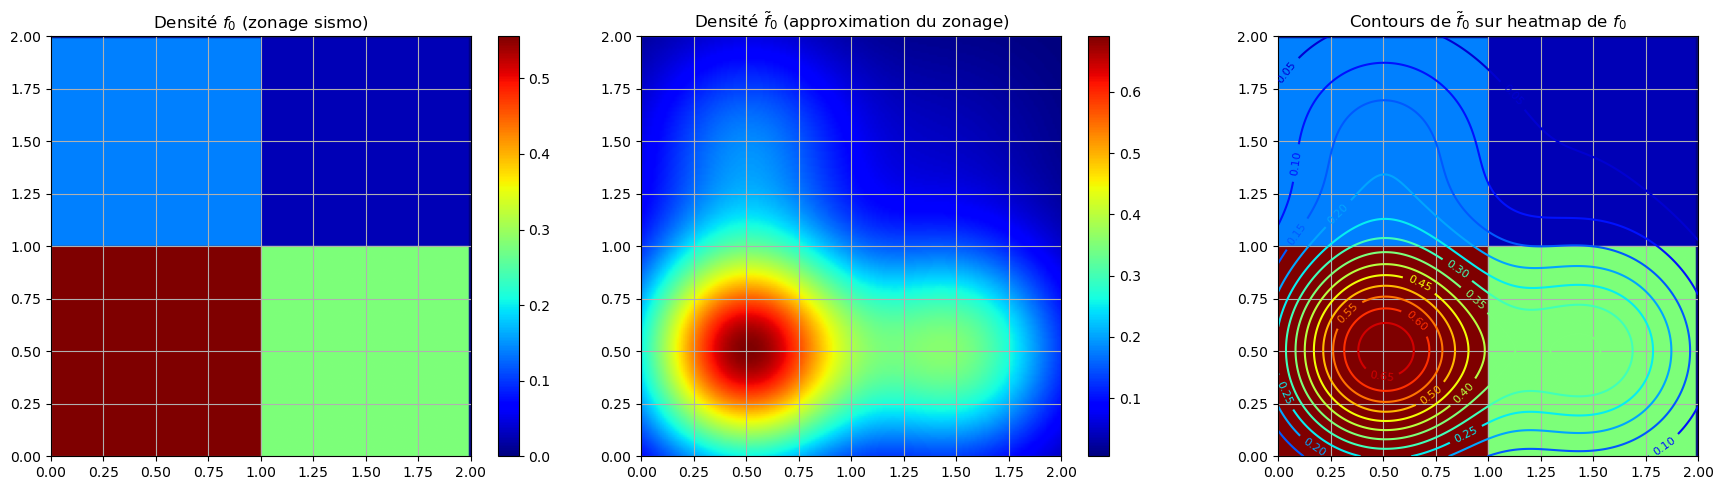

In [89]:
# ==================== Affichage heatmaps f_0 et \tilde{f}_0 + superposition ====================
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Densité f_0
im0 = axs[0].imshow(Z_f0, extent=(0, 2, 0, 2), origin='lower', cmap='jet')
axs[0].set_title("Densité $f_0$ (zonage sismo)")
axs[0].set_aspect('equal')
axs[0].grid(True)
fig.colorbar(im0, ax=axs[0])

# Densité f0_tilde
im1 = axs[1].imshow(Z_f0_tilde, extent=(0, 2, 0, 2), origin='lower', cmap='jet')
axs[1].set_title("Densité $\\tilde{f}_0$ (approximation du zonage)")
axs[1].set_aspect('equal')
axs[1].grid(True)
fig.colorbar(im1, ax=axs[1])

# Superposition (contours sur heatmap)
axs[2].imshow(Z_f0, extent=(0, 2, 0, 2), origin='lower', cmap='jet')
contour = axs[2].contour(X, Y, Z_f0_tilde, levels=15, cmap='jet')
axs[2].clabel(contour, inline=True, fontsize=8)
axs[2].set_title("Contours de $\\tilde{f}_0$ sur heatmap de $f_0$")
axs[2].set_aspect('equal')
axs[2].grid(True)

plt.tight_layout()
plt.show()


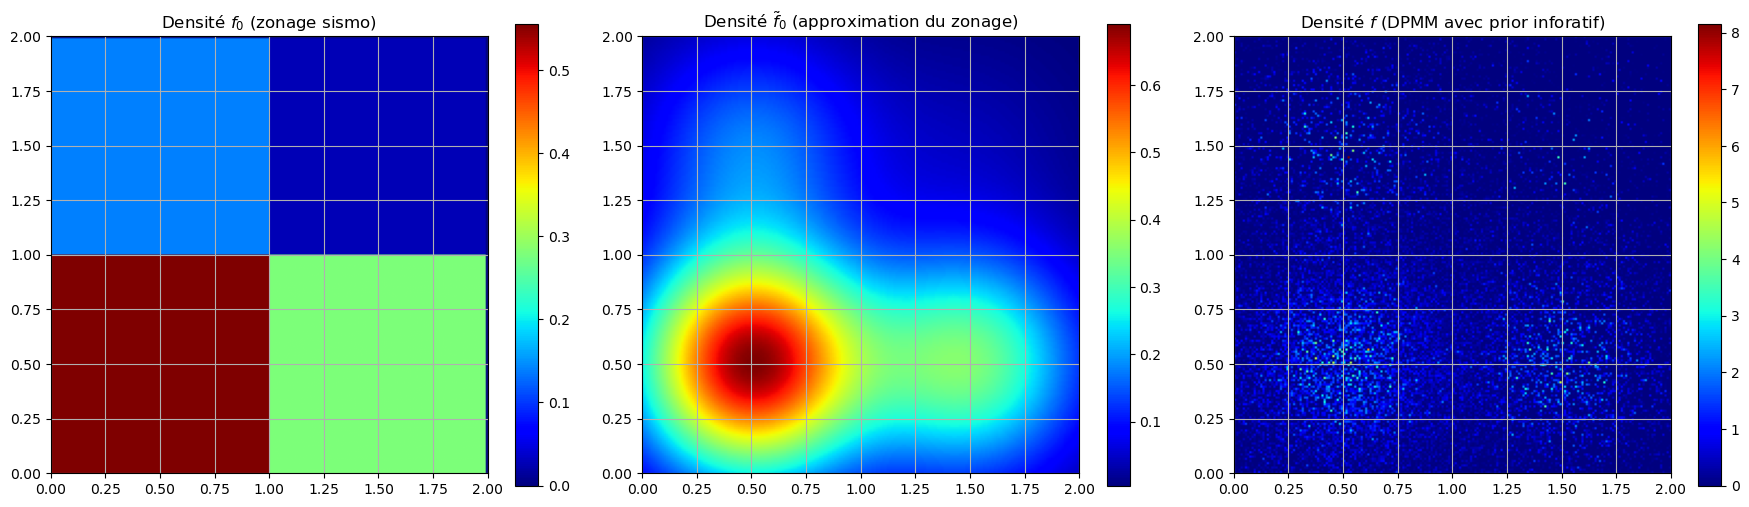

In [ ]:
# ==================== Affichage heatmaps de f_0, \tilde{f}_0 et f ====================
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Densité f_0
im0 = axs[0].imshow(Z_f0, extent=(0, 2, 0, 2), origin='lower', cmap='jet')
axs[0].set_title("Densité $f_0$ (zonage sismo)")
axs[0].set_aspect('equal')
axs[0].grid(True)
fig.colorbar(im0, ax=axs[0])

# Densité f0_tilde
im1 = axs[1].imshow(Z_f0_tilde, extent=(0, 2, 0, 2), origin='lower', cmap='jet')
axs[1].set_title("Densité $\\tilde{f}_0$ (approximation du zonage)")
axs[1].set_aspect('equal')
axs[1].grid(True)
fig.colorbar(im1, ax=axs[1])

# Densité f
im2 = axs[2].imshow(Z_f, extent=(0, 2, 0, 2), origin='lower', cmap='jet')
axs[2].set_title("Densité moyenne $\bar{f}_N$ (DPMM avec prior inforatif)")
axs[2].set_aspect('equal')
axs[2].grid(True)
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()


### Distance L2 entre $f_0$, $\tilde{f}_0$ et $f$

In [39]:
dx = x[1] - x[0]
dy = y[1] - y[0]

# ==================== Distance L2 entre f0 et f0_tilde ====================
squared_diff_f0_f0tilde = (Z_f0 - Z_f0_tilde) ** 2
L2_distance_f0_f0tilde = np.sqrt(np.sum(squared_diff_f0_f0tilde) * dx * dy)
print(f"Distance L2 entre f_0 et tilde(f)_0 : {L2_distance_f0_f0tilde:.4f}")

# ==================== Distance L2 entre f0 et f ====================
squared_diff_f0_f = (Z_f0 - Z_f) ** 2
L2_distance_f0_f = np.sqrt(np.sum(squared_diff_f0_f) * dx * dy)
print(f"Distance L2 entre f_0 et f : {L2_distance_f0_f:.4f}")

# ==================== Distance L2 entre f0_tilde et f ====================
squared_diff_f0tilde_f = (Z_f0_tilde - Z_f) ** 2
L2_distance_f0tilde_f = np.sqrt(np.sum(squared_diff_f0tilde_f) * dx * dy)
print(f"Distance L2 entre tilde(f)_0 et f : {L2_distance_f0tilde_f:.4f}")

Distance L2 entre f_0 et tilde(f)_0 : 0.2341
Distance L2 entre f_0 et f : 0.5811
Distance L2 entre tilde(f)_0 et f : 0.4661


alpha = 0.1000 -> Distance L2 = 0.5827
alpha = 2.5103 -> Distance L2 = 0.3061
alpha = 4.9207 -> Distance L2 = 0.2680
alpha = 7.3310 -> Distance L2 = 0.2703
alpha = 9.7414 -> Distance L2 = 0.3153
alpha = 12.1517 -> Distance L2 = 0.3165
alpha = 14.5621 -> Distance L2 = 0.3304
alpha = 16.9724 -> Distance L2 = 0.3215
alpha = 19.3828 -> Distance L2 = 0.3132
alpha = 21.7931 -> Distance L2 = 0.3323
alpha = 24.2034 -> Distance L2 = 0.2813
alpha = 26.6138 -> Distance L2 = 0.3472
alpha = 29.0241 -> Distance L2 = 0.2794
alpha = 31.4345 -> Distance L2 = 0.2711
alpha = 33.8448 -> Distance L2 = 0.2780
alpha = 36.2552 -> Distance L2 = 0.2982
alpha = 38.6655 -> Distance L2 = 0.3168
alpha = 41.0759 -> Distance L2 = 0.3036
alpha = 43.4862 -> Distance L2 = 0.3109
alpha = 45.8966 -> Distance L2 = 0.3420
alpha = 48.3069 -> Distance L2 = 0.2642
alpha = 50.7172 -> Distance L2 = 0.2765
alpha = 53.1276 -> Distance L2 = 0.2867
alpha = 55.5379 -> Distance L2 = 0.3019
alpha = 57.9483 -> Distance L2 = 0.2707
alpha

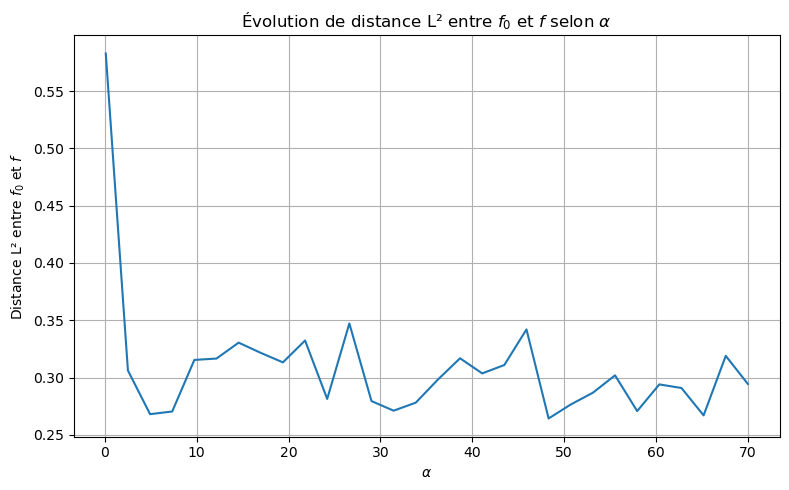

In [ ]:
#def density_dpmm(alpha):
#    weights = stick_breaking(alpha, tau)
#    prior = [sample_mixture_niw() for _ in range(len(weights))]
#    components = [ot.Normal(mu, sigma) for mu, sigma in prior]
#    return ot.Mixture(components, weights)

x = np.linspace(0, 2, 500)
y = np.linspace(0, 2, 500)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])
dx = x[1] - x[0]
dy = y[1] - y[0]

Z_f0 = np.vectorize(f0_density)(X, Y)

alphas = np.linspace(0.1, 70, 30)
L2_values = []

for alpha in alphas:
    mixture = density_dpmm(alpha)
    Z_f = np.array([mixture.computePDF(ot.Point(p)) for p in points]).reshape(X.shape)
    squared_diff = (Z_f - Z_f0) ** 2
    L2_dist = np.sqrt(np.sum(squared_diff) * dx * dy)
    L2_values.append(L2_dist)
    print(f"alpha = {alpha:.4f} -> Distance L2 = {L2_dist:.4f}")

# ===================== Affichage de la courbe distance L2 en fonction de alpha =====================
plt.figure(figsize=(8, 5))
plt.plot(alphas, L2_values)
plt.xlabel("$\\alpha$")
plt.ylabel("Distance L² entre $f_0$ et $f$")
plt.title("Évolution de distance L² entre $f_0$ et $f$ selon $\\alpha$")
plt.grid(True)
plt.tight_layout()
plt.show()


alpha = 0.1000 -> Distance L2 = 0.2460
alpha = 2.5103 -> Distance L2 = 0.3430
alpha = 4.9207 -> Distance L2 = 0.5004
alpha = 7.3310 -> Distance L2 = 0.2471
alpha = 9.7414 -> Distance L2 = 0.2061
alpha = 12.1517 -> Distance L2 = 0.1035
alpha = 14.5621 -> Distance L2 = 0.1545
alpha = 16.9724 -> Distance L2 = 0.1249
alpha = 19.3828 -> Distance L2 = 0.1900
alpha = 21.7931 -> Distance L2 = 0.1026
alpha = 24.2034 -> Distance L2 = 0.1459
alpha = 26.6138 -> Distance L2 = 0.0940
alpha = 29.0241 -> Distance L2 = 0.0896
alpha = 31.4345 -> Distance L2 = 0.1377
alpha = 33.8448 -> Distance L2 = 0.1826
alpha = 36.2552 -> Distance L2 = 0.1373
alpha = 38.6655 -> Distance L2 = 0.1444
alpha = 41.0759 -> Distance L2 = 0.1056
alpha = 43.4862 -> Distance L2 = 0.1507
alpha = 45.8966 -> Distance L2 = 0.1792
alpha = 48.3069 -> Distance L2 = 0.1634
alpha = 50.7172 -> Distance L2 = 0.1591
alpha = 53.1276 -> Distance L2 = 0.1569
alpha = 55.5379 -> Distance L2 = 0.0887
alpha = 57.9483 -> Distance L2 = 0.1476
alpha

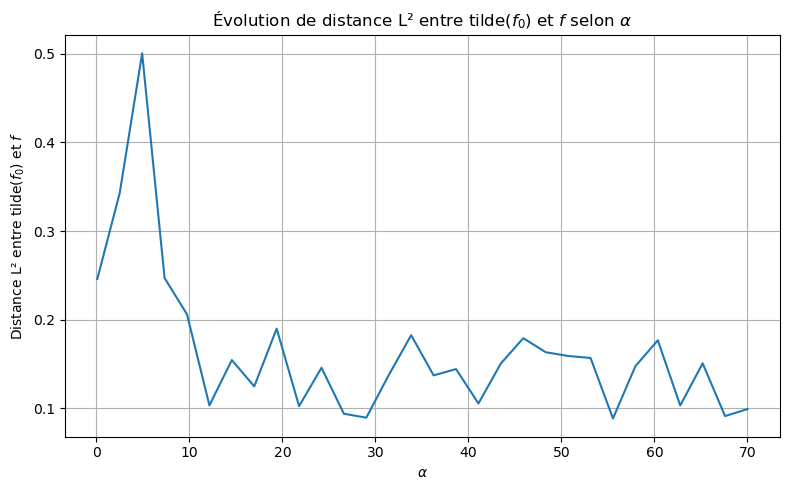

In [43]:
#def density_dpmm(alpha):
#    weights = stick_breaking(alpha, tau)
#    prior = [sample_mixture_niw() for _ in range(len(weights))]
#    components = [ot.Normal(mu, sigma) for mu, sigma in prior]
#    return ot.Mixture(components, weights)

x = np.linspace(0, 2, 500)
y = np.linspace(0, 2, 500)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])
dx = x[1] - x[0]
dy = y[1] - y[0]

Z_f0_tilde = np.vectorize(f0_tilde_density)(X, Y)

alphas = np.linspace(0.1, 70, 30)
L2_values = []

for alpha in alphas:
    mixture = density_dpmm(alpha)
    Z_f = np.array([mixture.computePDF(ot.Point(p)) for p in points]).reshape(X.shape)
    squared_diff = (Z_f - Z_f0_tilde) ** 2
    L2_dist = np.sqrt(np.sum(squared_diff) * dx * dy)
    L2_values.append(L2_dist)
    print(f"alpha = {alpha:.4f} -> Distance L2 = {L2_dist:.4f}")

# ===================== Affichage de la courbe distance L2 en fonction de alpha =====================
plt.figure(figsize=(8, 5))
plt.plot(alphas, L2_values)
plt.xlabel("$\\alpha$")
plt.ylabel("Distance L² entre tilde($f_0$) et $f$")
plt.title("Évolution de distance L² entre tilde($f_0$) et $f$ selon $\\alpha$")
plt.grid(True)
plt.tight_layout()
plt.show()

## DPMM avec prior non informatif (NIW)

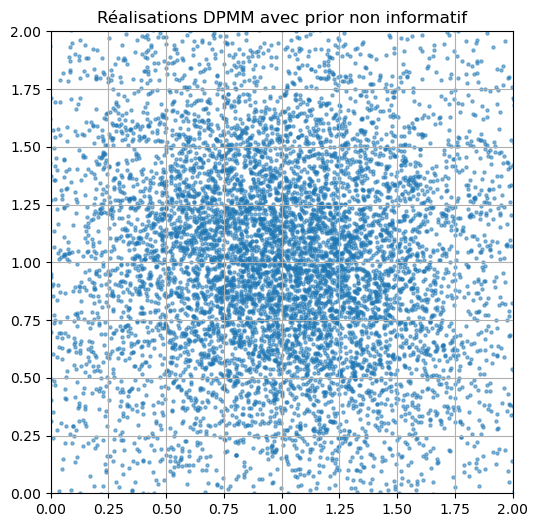

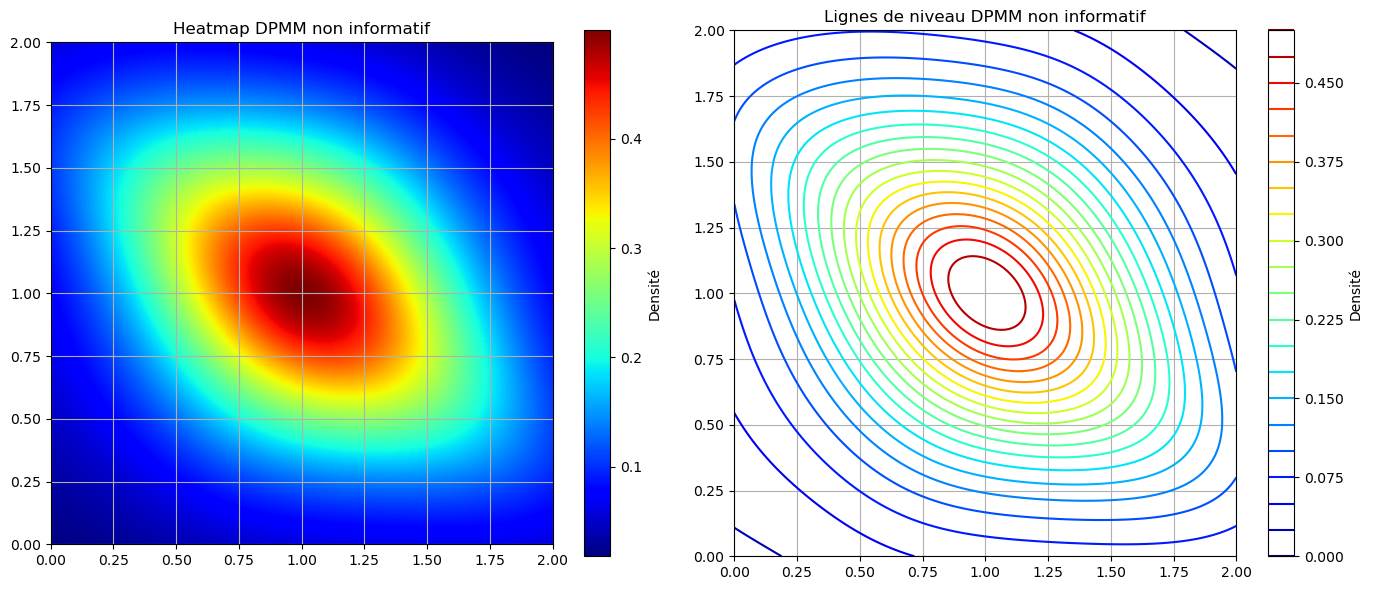

In [67]:
dim = 2
n_samples = 10000
alpha = 20.0
tau = 1e-2

mu_0 = ot.Point([1.0, 1.0])
lambda_0 = 100.0
nu_0 = 4.0
Psi_0 = ot.CovarianceMatrix([[1.0 * (nu_0 - 3), 0.0], [0.0, 1.0 * (nu_0 - 3)]])

def sample_niw():
    Sigma = ot.InverseWishart(Psi_0, nu_0).getRealizationAsMatrix()
    mu = ot.Normal(mu_0, ot.CovarianceMatrix(Sigma / lambda_0)).getRealization()
    return mu, Sigma

def stick_breaking(alpha, tau=1e-3):
    weights = []
    r = 1.0
    while r > tau:
        v = ot.Beta(1.0, alpha, 0.0, 1.0).getRealization()[0]
        w = v * r
        weights.append(w)
        r *= (1 - v)
    return np.array(weights) / np.sum(weights)

def sample_dpmm_noninformative(n_samples=1000):
    weights = stick_breaking(alpha, tau)
    prior = [sample_niw() for _ in range(len(weights))]

    data = []
    for _ in range(n_samples):
        k = np.random.choice(len(weights), p=weights)
        mu_k, sigma_k = prior[k]
        point = ot.Normal(mu_k, sigma_k).getRealization()
        data.append(list(point))

    return np.array(data)

def density_dpmm_noninformative():
    weights = stick_breaking(alpha, tau)
    prior = [sample_niw() for _ in range(len(weights))]
    components = [ot.Normal(mu, sigma) for mu, sigma in prior]
    return ot.Mixture(components, weights)


# ============================== Affichage ==============================
samples = sample_dpmm_noninformative(n_samples)
plt.figure(figsize=(7, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.title("Réalisations DPMM avec prior non informatif")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# ======================== Affichage densité estimée ========================
mixture_density = density_dpmm_noninformative()

x = np.linspace(0, 2, 500)
y = np.linspace(0, 2, 500)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])
Z = np.array([mixture_density.computePDF(ot.Point(p)) for p in points])
Z = Z.reshape(X.shape)

# =========================== Heatmap + lignes de niveau ===========================
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

heatmap = axs[0].imshow(Z, extent=[0, 2, 0, 2], origin='lower', cmap='jet')
axs[0].set_title("Heatmap DPMM non informatif")
axs[0].grid(True)
fig.colorbar(heatmap, ax=axs[0], label="Densité")

contour = axs[1].contour(X, Y, Z, levels=20, cmap='jet')
axs[1].set_title("Lignes de niveau DPMM non informatif")
axs[1].grid(True)
fig.colorbar(contour, ax=axs[1], label="Densité")

plt.tight_layout()
plt.show()


In [69]:
(1/1.96)**2

0.2603082049146189

In [63]:
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])
dx = x[1] - x[0]
dy = y[1] - y[0]

def density_dpmm_noninformative():
    weights = stick_breaking(alpha, tau)
    prior = [sample_niw() for _ in range(len(weights))]
    components = [ot.Normal(mu, sigma) for mu, sigma in prior]
    return ot.Mixture(components, weights)

def density_dpmm(alpha=20):
    weights = stick_breaking(alpha, tau)
    prior = [sample_mixture_niw() for _ in range(len(weights))]
    components = [ot.Normal(mu, sigma) for mu, sigma in prior]
    return ot.Mixture(components, weights)


Z_f0 = np.vectorize(f0_density)(X, Y)

Z_f = np.array([density_dpmm().computePDF(ot.Point(p)) for p in points])
Z_f = Z_f.reshape(X.shape)

Z_f_noninformative = np.array([density_dpmm_noninformative().computePDF(ot.Point(p)) for p in points])
Z_f_noninformative = Z_f_noninformative.reshape(X.shape)

# ==================== Distance L2 entre f et f_noninformative ====================
squared_diff_f_fni = (Z_f - Z_f_noninformative) ** 2
L2_distance_f_fni = np.sqrt(np.sum(squared_diff_f_fni) * dx * dy)
print(f"Distance L2 entre f et f_noninformative : {L2_distance_f_fni:.4f}")

# ==================== Distance L2 entre f_0 et f_noninformative ====================
squared_diff_f0_fni = (Z_f0 - Z_f_noninformative) ** 2
L2_distance_f0_fni = np.sqrt(np.sum(squared_diff_f0_fni) * dx * dy)
print(f"Distance L2 entre f_0 et f_noninformative : {L2_distance_f0_fni:.4f}")

# ==================== Distance L2 entre f_0 et f ====================
squared_diff_f0_f = (Z_f0 - Z_f) ** 2
L2_distance_f0_f = np.sqrt(np.sum(squared_diff_f0_f) * dx * dy)
print(f"Distance L2 entre f_0 et f : {L2_distance_f0_f:.4f}")



Distance L2 entre f et f_noninformative : 0.3662
Distance L2 entre f_0 et f_noninformative : 0.5349
Distance L2 entre f_0 et f : 0.3282


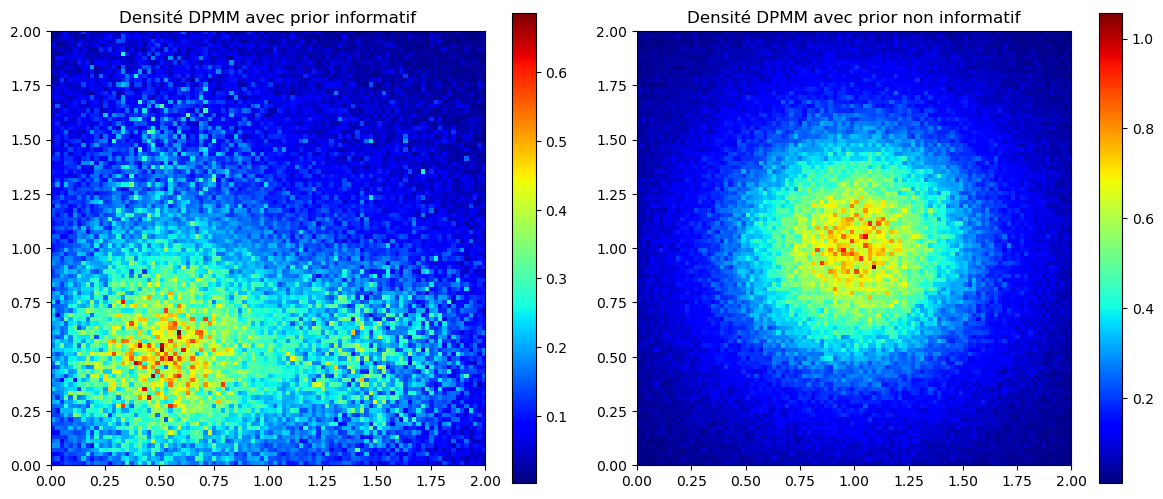

In [64]:
# ============================== Affichage ==============================
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

im0 = axs[0].imshow(Z_f, extent=(0, 2, 0, 2), origin='lower', cmap='jet')
axs[0].set_title("Densité DPMM avec prior informatif")
axs[0].set_aspect('equal')
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(Z_f_noninformative, extent=(0, 2, 0, 2), origin='lower', cmap='jet')
axs[1].set_title("Densité DPMM avec prior non informatif")
axs[1].set_aspect('equal')
fig.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()

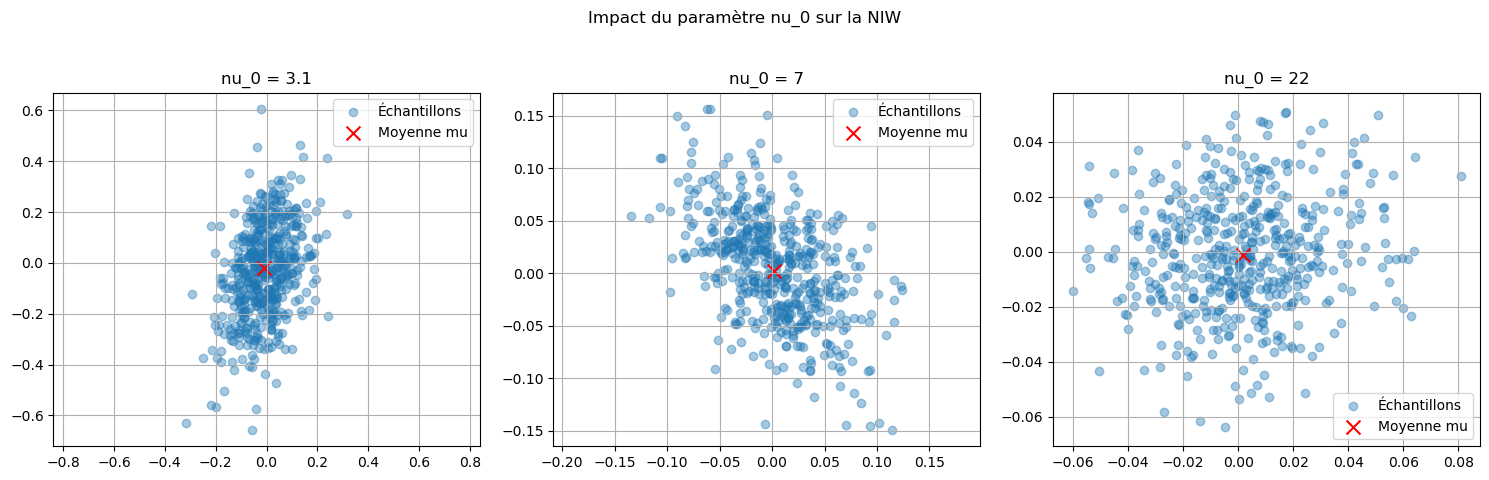

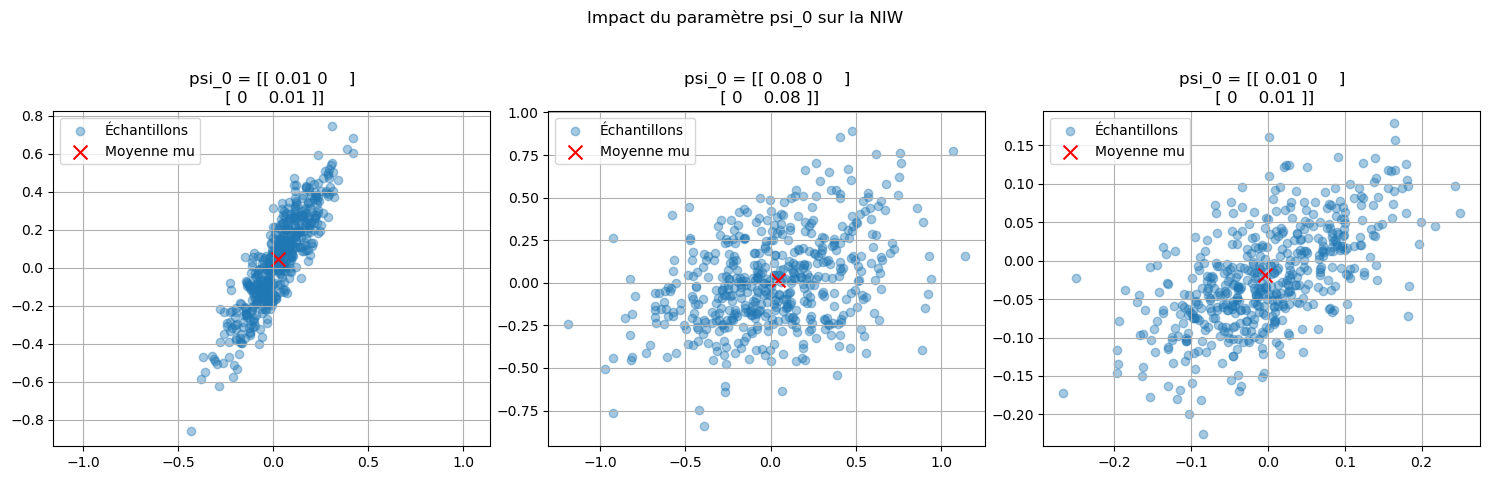

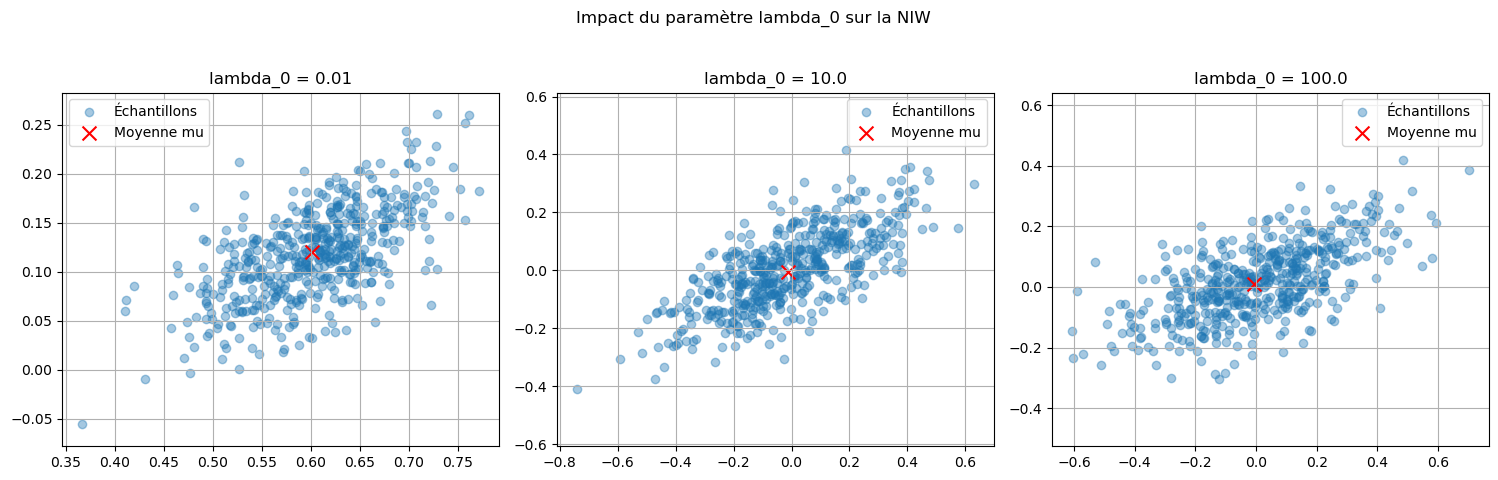

In [ ]:
dim = 2
n_sample = 500
mu_0 = ot.Point([0.0, 0.0])

def plot_params_effects(param_name, param_values, fixed_params):
    fig, axes = plt.subplots(1, len(param_values), figsize=(5 * len(param_values), 5))

    if len(param_values) == 1:
        axes = [axes]

    for ax, val in zip(axes, param_values):
        # ************************ Définition des paramètres en fonction de qu'on varie ************************
        if param_name == 'nu_0':
            nu_0 = val
            psi_0 = fixed_params['psi_0']
            lambda_0 = fixed_params['lambda_0']
        elif param_name == 'psi_0':
            nu_0 = fixed_params['nu_0']
            psi_0 = val
            lambda_0 = fixed_params['lambda_0']
        elif param_name == 'lambda_0':
            nu_0 = fixed_params['nu_0']
            psi_0 = fixed_params['psi_0']
            lambda_0 = val
        else:
            raise ValueError("param_name doit être 'nu_0', 'psi_0' ou 'lambda_0'")

        # ************************ Tirage NIW ************************
        Sigma = ot.InverseWishart(psi_0, nu_0).getRealizationAsMatrix()
        mu = ot.Normal(mu_0, ot.CovarianceMatrix(Sigma / lambda_0)).getRealization()
        sample = ot.Normal(mu, Sigma).getSample(n_sample)

        # ************************************ Plots ************************************
        ax.scatter(sample[:, 0], sample[:, 1], alpha=0.4, label='Échantillons')
        ax.scatter(mu[0], mu[1], c='red', marker='x', s=100, label='Moyenne mu')
        ax.set_title(f"{param_name} = {val if param_name != 'psi_0' else val[:,:]}")
        ax.axis('equal')
        ax.grid(True)
        ax.legend()


    plt.suptitle(f"Impact du paramètre {param_name} sur la NIW")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# ****************************** Paramètres fixes par défaut ******************************
nu_0_default = dim + 1.1
psi_0_default = ot.CovarianceMatrix([[0.1*(nu_0_default-3), 0.00], [0.00, 0.1*(nu_0_default-3)]])
lambda_0_default = 100.0

# Variation de nu_0
nu_0s = [dim + 1.1, dim + 5, dim + 20]
plot_params_effects('nu_0', nu_0s, {'psi_0': psi_0_default, 'lambda_0': lambda_0_default, 'nu_0': nu_0_default})

# Variation de psi_0
psi_0s = [
    ot.CovarianceMatrix([[0.1*(nu_0_default-3), 0.0], [0.0, 0.1*(nu_0_default-3)]]),
    ot.CovarianceMatrix([[0.8*(nu_0_default-3), 0.0], [0.0, 0.8*(nu_0_default-3)]]),
    ot.CovarianceMatrix([[0.1*(nu_0_default-3), 0.0], [0.0, 0.1*(nu_0_default-3)]])
]
plot_params_effects('psi_0', psi_0s, {'psi_0': psi_0_default, 'lambda_0': lambda_0_default, 'nu_0': nu_0_default})

# Variation de lambda_0
lambda_0s = [0.01, 10.0, 100.0]
plot_params_effects('lambda_0', lambda_0s, {'psi_0': psi_0_default, 'lambda_0': lambda_0_default, 'nu_0': nu_0_default})

